In [1]:
%matplotlib notebook
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd

from nansat import Nansat

In [2]:
def get_occci_data(date, band='chlor_a',
                     lon_lim=[-85, -25], lat_lim=[20, 55],
                     try_max=10, try_n=0):
    ''' Get data from OC CCI in several attepmts
    
    Parameters:
        date : datetime
            date for which data is needed
        band : str
            name of the band
        lon_lim : [float, float]
            longitude limits
        lat_lim : [float, float]
            latitude limits
        try_max : int
            max number of attempts
        try_n : int
            current number of attempt
    Returns:
        data : ndarray
            matrix with requested values
        '''
    # url = 'https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v2.0-DAILY'
    url = 'https://esgf-data1.ceda.ac.uk/thredds/dodsC/esg_esacci/ocean_colour/data/v2-release/geographic/netcdf/chlor_a/daily/v2.0/%Y/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km_GEO_PML_OC4v6-%Y%m%d-fv2.0.nc'
    url_date = date.strftime(url)
    #print url_date
    #n = Nansat(url_date, bands=[band])
    try:
        n = Nansat(url_date, bands=[band])
        n.crop_lonlat(lon_lim, lat_lim)
        data = n[band]
    except:
        print 'Error retrieving chlor_a in attempt', try_n
        if try_n < try_max:
            data, n = get_occci_data(date, lon_lim=lon_lim, lat_lim=lat_lim, try_max=try_max, try_n=try_n+1)
        else:
            data, n = None, None

    return data, n

In [3]:
def get_data_for_eddies(data, n, lons, lats, rads, resx=3.8, resy=4.6):
    ''' Extract values from raster for given coordinates

    Paramaters:
        data : 2D ndarray
            array with raster data (e.g. chlorophyll)
        n : Nansat
            Nansat object that corresponds to the array
        lons : 1D ndarray
            eddy longitudes
        lats : 1D ndarray
            eddy latitudes
        rads : 1D ndarray
            eddy radius
        resx : float
            X resoluion of the grid in KM
        resy : float
            Y resoluion of the grid in KM
    Returns:
        stats : 2D array
            Matrix with mean, median, STD and counts in columns
        '''
    # get eddies coordinates and radius (in pixels )
    cols, rows = np.round(n.transform_points(lons, lats, 1)).astype(int)
    drows = np.floor(rads / resy).astype(int)
    dcols = np.floor(rads / resx).astype(int)

    data_stats = []
    # loop over individual eddies
    for (row, col, drow, dcol, rad) in zip(rows, cols, drows, dcols, rads):
        # distance in KM from center
        xdist = np.linspace(-dcol*resx, dcol*resx, dcol*2+1)
        ydist = np.linspace(-drow*resy, drow*resy, drow*2+1)
        xgrd, ygrd = np.meshgrid(xdist, ydist)
        dist = np.hypot(xgrd, ygrd)
        # subset of data within radius
        data_subset = data[row-drow:row+drow+1, col-dcol:col+dcol+1][dist < rad]
        # collect stats
        data_stats.append((np.nanmean(data_subset),
                           np.nanmedian(data_subset),
                           np.nanstd(data_subset),
                           len(data_subset[np.isfinite(data_subset)])))
    
    return np.array(data_stats)

In [4]:
### LOAD DATAFRAME FROM FILE (presaved or netCDF)
ifilename = 'NA_anticycloniceddies.nc'
ofilename = ifilename + '.pickle'

if os.path.exists(ofilename):
    # load presaved dataset
    df = pd.read_pickle(ofilename)
else:
    # open eddy file and read all values
    ds = Dataset(ifilename)
    df = pd.DataFrame({key:ds.variables[key][:] for key in ds.variables.keys()})
    # add date variable
    df['date'] = pd.Series([dt.datetime(yy,mm,dd)
                             for (yy,mm,dd) in zip(df['year'].astype(int),
                                                   df['month'].astype(int),
                                                   df['day'].astype(int))])
    df = df.drop('year', 1)
    df = df.drop('month', 1)
    df = df.drop('day', 1)
    # save dataframe for further use
    df.to_pickle(ofilename)

# find unique dates for the OC CCI period
dates_uniq = df.date[df.date >= dt.datetime(1997, 9, 4)].unique()
print len(dates_uniq)

6693


In [5]:
# loop over unique dates
for date in dates_uniq[:55]:
    date = pd.to_datetime(str(date))
    print date

    # skip if that date was already processed
    if np.all(np.isfinite(df.chl_cnt[df.date == date])):
        print 'already OK'
        continue

    print 'Processing ...'
    # get chlorophyll data from OC CCI for this date
    chlor_a, n = get_occci_data(date)
    if chlor_a is None:
        print 'no CHL'
        continue

    print 'Extract CHL'
    # find eddies for this date
    gpi = df.date == date

    # find chlor_a data for the eddies
    stats = get_data_for_eddies(chlor_a, n, df.lon[gpi], df.lat[gpi], df.Radius[gpi])

    # add results to the data frame
    df.chl_avg[df.date == date] = stats[:, 0]
    df.chl_med[df.date == date] = stats[:, 1]
    df.chl_std[df.date == date] = stats[:, 2]
    df.chl_cnt[df.date == date] = stats[:, 3]

    # save results
    df.to_pickle(ofilename)

1997-09-04 00:00:00
already OK
1997-09-05 00:00:00
already OK
1997-09-06 00:00:00
already OK
1997-09-07 00:00:00
already OK
1997-09-08 00:00:00
already OK
1997-09-09 00:00:00
already OK
1997-09-10 00:00:00
already OK
1997-09-11 00:00:00
already OK
1997-09-12 00:00:00
already OK
1997-09-13 00:00:00
already OK
1997-09-14 00:00:00
Processing ...


/home/antonk/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:148: UserWarning: 
            Date is not specified! Will return the first layer.
            Please add date="YYYY-MM-DD"
  Please add date="YYYY-MM-DD"''')


Error retrieving chlor_a in attempt 0
Error retrieving chlor_a in attempt 1
Error retrieving chlor_a in attempt 2
Error retrieving chlor_a in attempt 3
Error retrieving chlor_a in attempt 4
Error retrieving chlor_a in attempt 5
Error retrieving chlor_a in attempt 6
Error retrieving chlor_a in attempt 7
Error retrieving chlor_a in attempt 8
Error retrieving chlor_a in attempt 9
Error retrieving chlor_a in attempt 10
no CHL
1997-09-15 00:00:00
already OK
1997-09-16 00:00:00
already OK
1997-09-17 00:00:00
Processing ...
Error retrieving chlor_a in attempt 0
Error retrieving chlor_a in attempt 1
Error retrieving chlor_a in attempt 2
Error retrieving chlor_a in attempt 3
Error retrieving chlor_a in attempt 4
Error retrieving chlor_a in attempt 5
Error retrieving chlor_a in attempt 6
Error retrieving chlor_a in attempt 7
Error retrieving chlor_a in attempt 8
Error retrieving chlor_a in attempt 9
Error retrieving chlor_a in attempt 10
no CHL
1997-09-18 00:00:00
already OK
1997-09-19 00:00:00


/home/antonk/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:89: UserWarning: Time consuming loading time from OpenDAP...
  warnings.warn('Time consuming loading time from OpenDAP...')
/home/antonk/miniconda/lib/python2.7/site-packages/nansat/mappers/opendap.py:91: UserWarning: Loading time - OK!
  warnings.warn('Loading time - OK!')


Extract CHL


/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/home/antonk/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/antonk/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1997-10-25 00:00:00
Processing ...
Extract CHL
1997-10-26 00:00:00
Processing ...
Extract CHL
1997-10-27 00:00:00
Processing ...
Extract CHL
1997-10-28 00:00:00
Processing ...
Extract CHL


/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


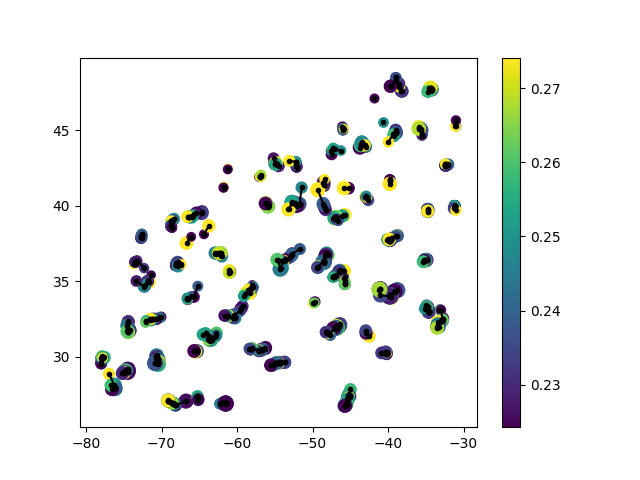

/home/antonk/miniconda/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [6]:
# example of analysis
# map of eddies colord by average CHL
df = pd.read_pickle(ofilename)
gpi = np.isfinite(df.chl_avg)
ed_ids = np.unique(df.ID[gpi])
plt.figure()
for ed_id in ed_ids:
    gpi2 = gpi * (df.ID == ed_id)
    plt.plot(df.lon[gpi2], df.lat[gpi2], 'k.-')
    plt.scatter(df.lon[gpi2], df.lat[gpi2], df.Radius[gpi2], df.chl_avg[gpi2])

plt.colorbar()

<IPython.core.display.Javascript object>


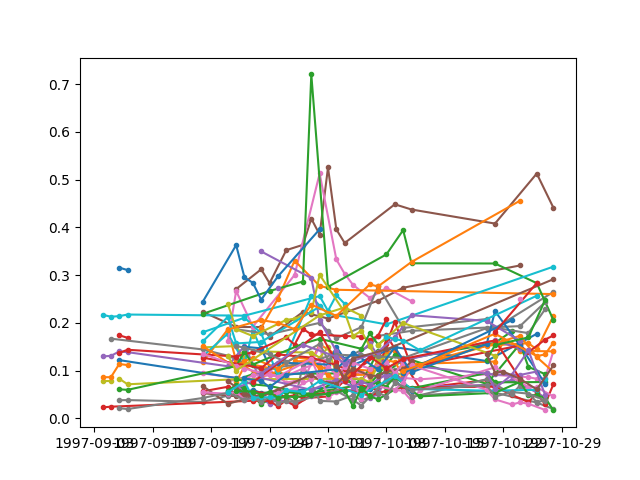

In [7]:
# example of analysis
# time series of eddies
plt.figure()
for ed_id in ed_ids:
    gpi2 = gpi * (df.ID == ed_id)
    plt.plot(df.date[gpi2], df.chl_avg[gpi2], '.-')
